In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data loading

dataset = pd.read_csv('/content/drive/MyDrive/clast/Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))
dataset.head()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


In [ ]:
nulls = dataset.isna().sum()
nulls.sum()

0

Пропусков нет

In [ ]:
dataset.shape

(23479, 500)

Text(0, 0.5, 'bit ADC')

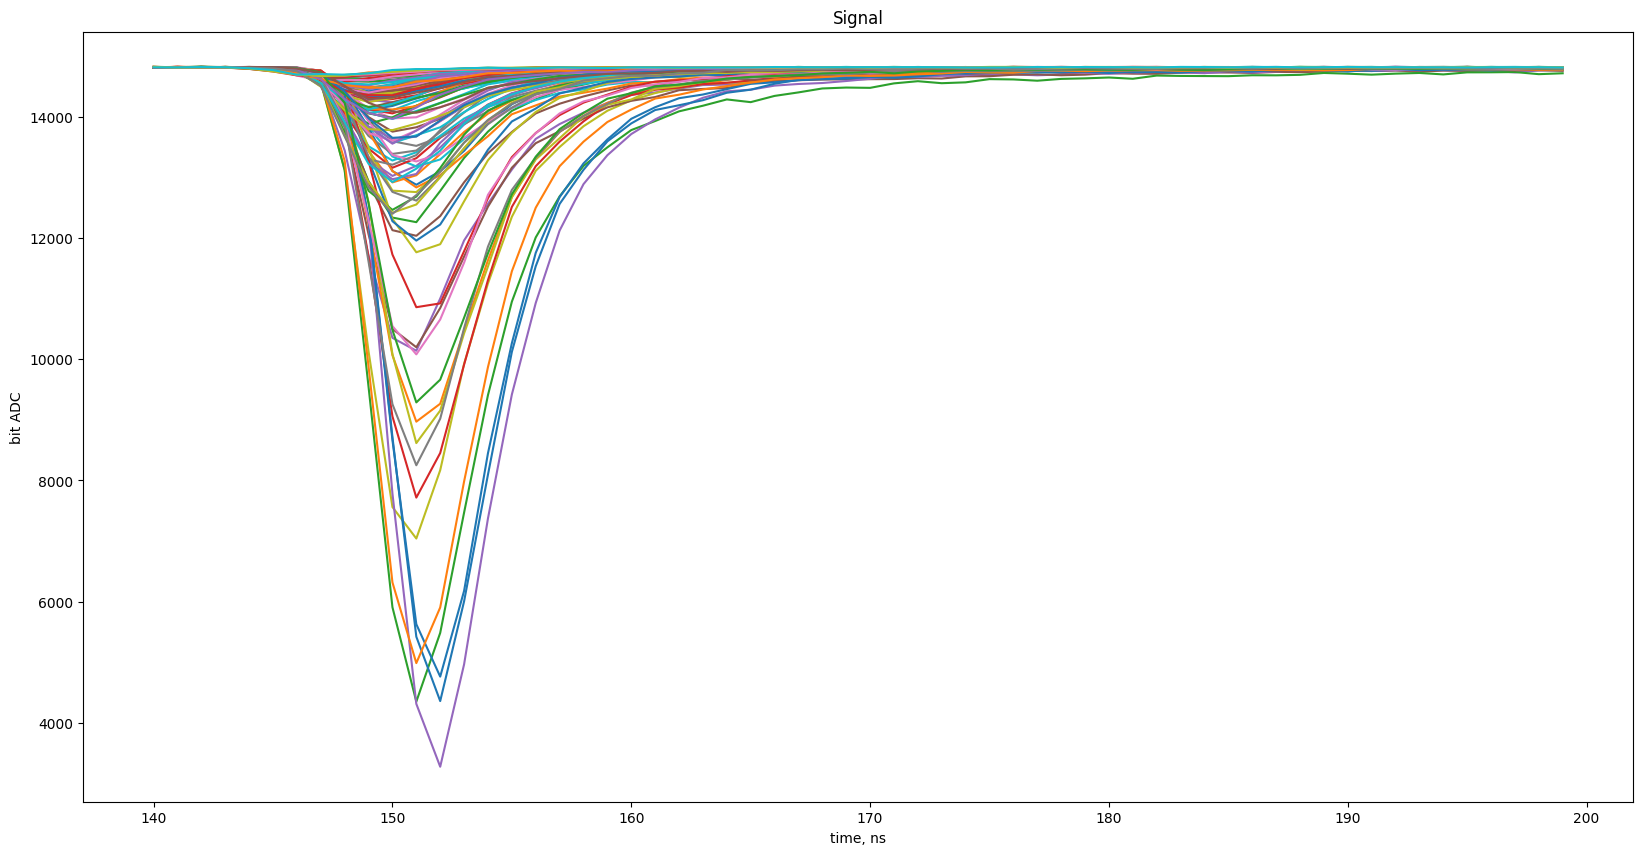

In [ ]:
N=range(0,100)
ax = dataset.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Text(0, 0.5, 'bit ADC')

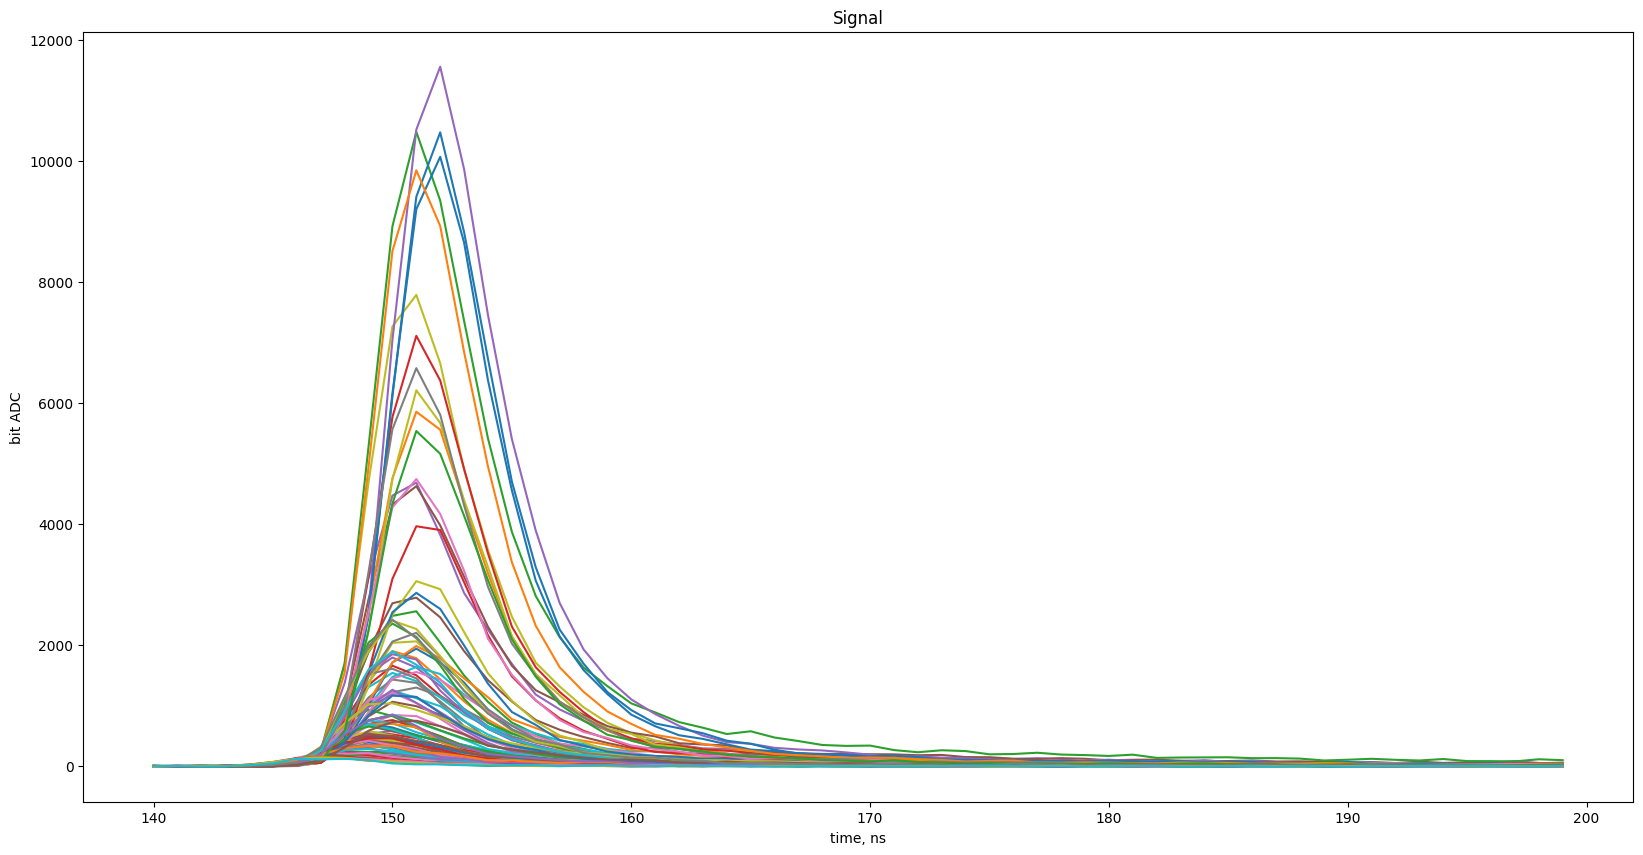

In [ ]:
ax = (2**14-dataset.T[N]-1560)[140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")


In [ ]:
from scipy.integrate import simpson

areas = np.array([0]*23479)
amplitudes = np.array([0]*23479)
for i in range(23479):
  x = np.array(2**14-dataset.T[i]-1560)
  areas[i] = simpson(y=x, x=np.arange(0, len(x)))
  amplitudes[i] = max(x) - min(x)

df = pd.DataFrame({'s': areas, 'a': amplitudes})
df.index.name = 'index'
df

,s,a
index,,
0,5974,539
1,13095,1907
2,17948,2566
3,5223,573
4,12887,1800
...,...,...
23474,3295,512
23475,45791,5774
23476,39504,5004


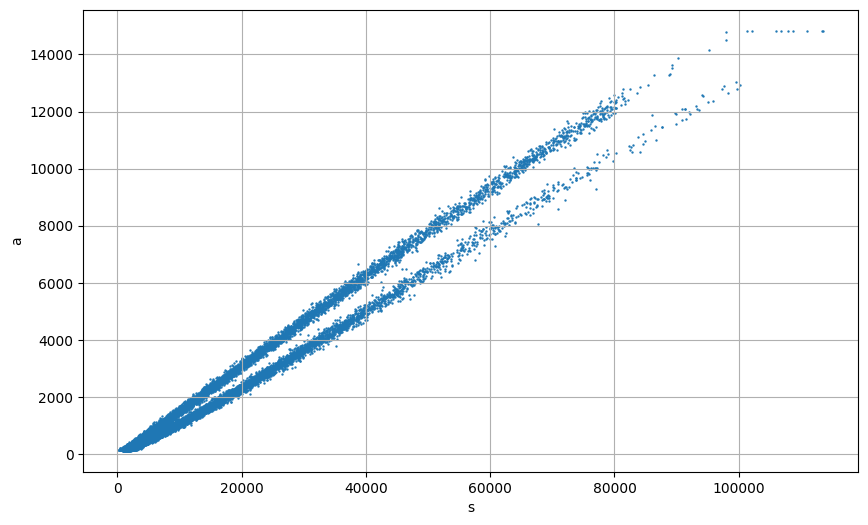

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['s'], df['a'], s=0.5)
plt.xlabel('s')
plt.ylabel('a')
plt.grid()

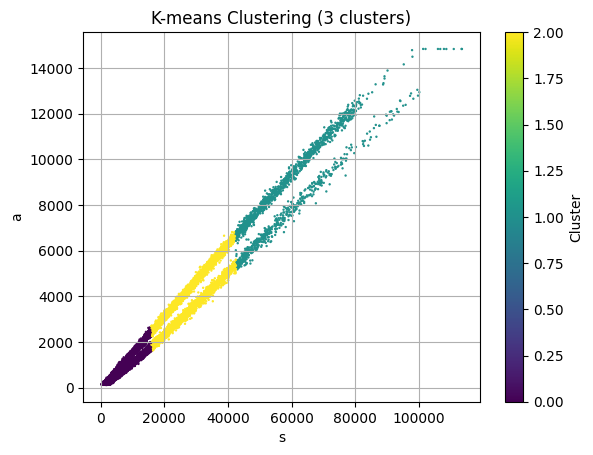

Silhouette Score: 0.6935778491883814
Score: 78408.43541736362


In [ ]:
from sklearn.cluster import KMeans

# Создаем модель KMeans с 3 кластерами
kmeans = KMeans(n_clusters=3, random_state=42)

# Применяем модель к данным
df['cluster'] = kmeans.fit_predict(df[['s', 'a']])

# Визуализация
plt.scatter(df['s'], df['a'], c=df['cluster'], cmap='viridis', s=0.5)
plt.title('K-means Clustering (3 clusters)')
plt.xlabel('s')
plt.ylabel('a')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

X = df[['s', 'a']].values
y = df['cluster'].values
silhouette_avg = silhouette_score(X, y)
calinski_harabasz_index = calinski_harabasz_score(X, y)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Score: {calinski_harabasz_index}")

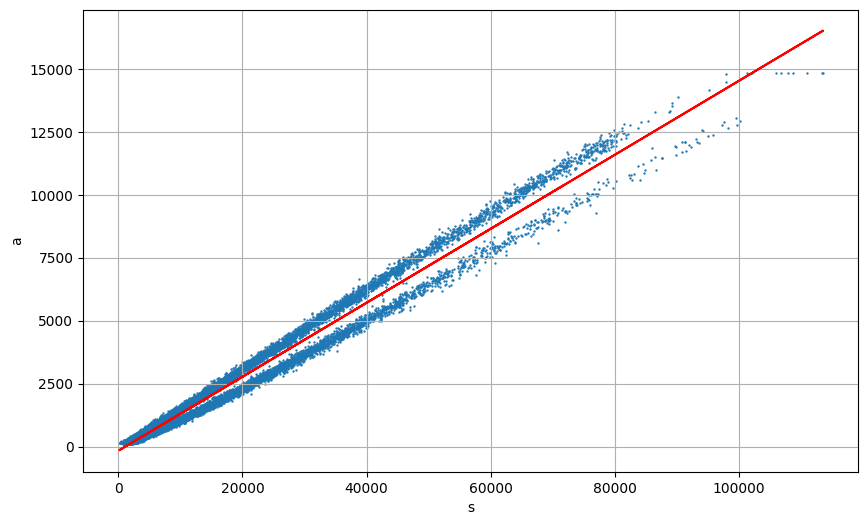

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['s'], df['a'], s=0.5)
plt.xlabel('s')
plt.ylabel('a')
plt.grid()

# Преобразуем данные в массивы numpy
X = df['s'].values.reshape(-1, 1)
Y = df['a'].values

X = np.hstack((np.ones((X.shape[0], 1)), X))

beta = np.linalg.inv(X.T @ X) @ X.T @ Y

# Коэффициенты
c = beta[0]
b = beta[1]

plt.plot(X, b*X + c, c='r')

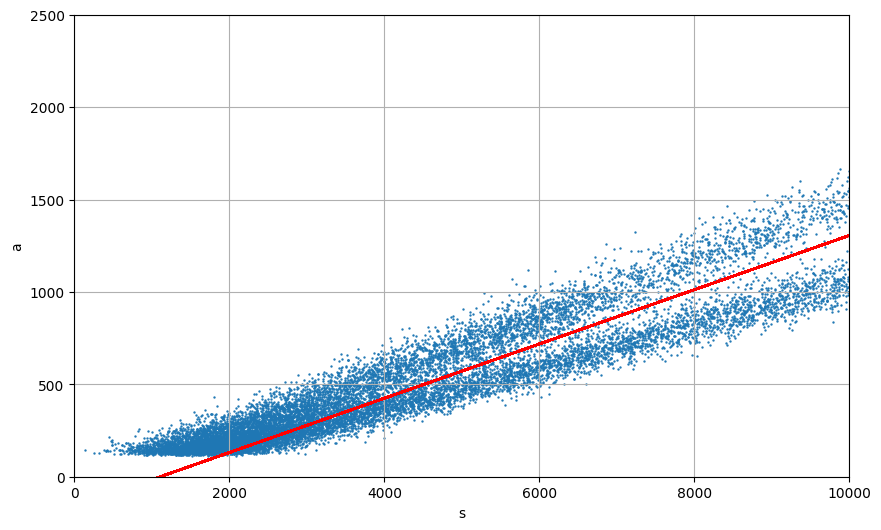

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['s'], df['a'], s=0.5)
plt.xlabel('s')
plt.ylabel('a')
plt.xlim(0, 10000)
plt.ylim(0, 2500)
plt.grid()
plt.plot(X, b*X + c, c='r')

Используем статистический подход, найдем 2 линии по МНК, которые будут хорошо описывать четко определнные типы частиц (верхний и нижний пучок). Вдоль прямых найдем отклонение и дисперсию данных и в третий кластер будем собирать частицы, которые выходят за диапазон 3 сигма от этих лучей

(0.0, 2500.0)

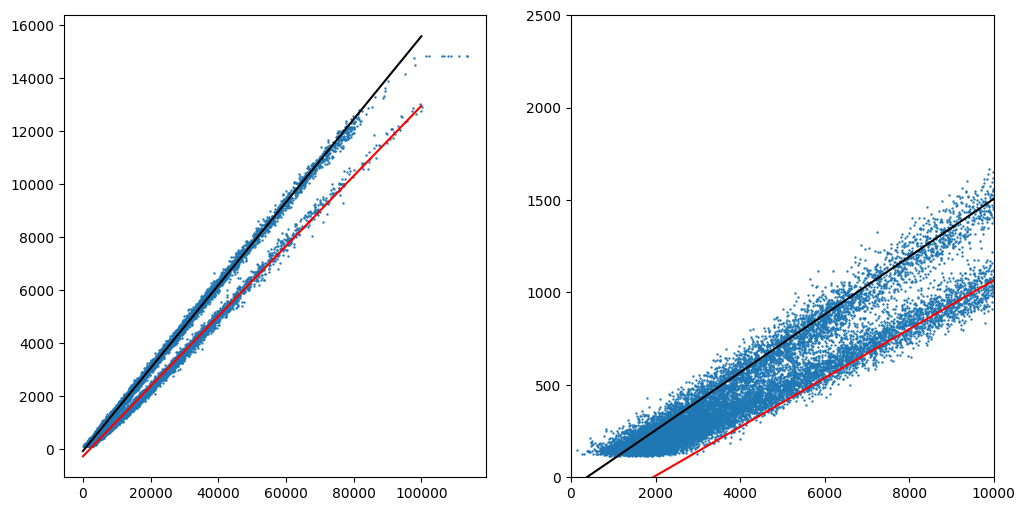

In [ ]:
df_up = df[(df['s']>4000) & (df['s']*b+c>df['a'])]
df_down = df[(df['s']>4000) & (df['s']*b+c<df['a'])]

X1 = df_up['s'].values.reshape(-1, 1)
Y1 = df_up['a'].values
X1 = np.hstack((np.ones((X1.shape[0], 1)), X1))
beta = np.linalg.inv(X1.T @ X1) @ X1.T @ Y1
c1= beta[0]
b1 = beta[1]

X2 = df_down['s'].values.reshape(-1, 1)
Y2 = df_down['a'].values
X2 = np.hstack((np.ones((X2.shape[0], 1)), X2))
beta = np.linalg.inv(X2.T @ X2) @ X2.T @ Y2
c2= beta[0]
b2 = beta[1]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

x = np.arange(0, 100000, 1)
ax[0].plot(x, b1*x + c1, c='r')
ax[0].plot(x, b2*x + c2, c='black')
ax[0].scatter(df['s'], df['a'], s=0.5)
ax[1].plot(x, b1*x + c1, c='r')
ax[1].plot(x, b2*x + c2, c='black')
ax[1].scatter(df['s'], df['a'], s=0.5)
ax[1].set_xlim(0, 10000)
ax[1].set_ylim(0, 2500)

In [ ]:
# Создаем копии DataFrame
df_up = df_up.copy()
df_down = df_down.copy()

# Углы наклона прямых
theta1 = np.arctan(b1)
theta2 = np.arctan(b2)

# Углы перпендикулярных осей
theta_perp1 = theta1 + np.pi / 2
theta_perp2 = theta2 + np.pi / 2

# Проекции точек на перпендикулярные оси
df_up.loc[:, 'projection_perp1'] = -df_up['s'] * np.sin(theta1) + (df_up['a'] - c1) * np.cos(theta1)
df_down.loc[:, 'projection_perp2'] = -df_down['s'] * np.sin(theta2) + (df_down['a'] - c2) * np.cos(theta2)

# Дисперсия проекций
variance_perp1 = np.var(df_up['projection_perp1'])
variance_perp2 = np.var(df_down['projection_perp2'])

print(f"Дисперсия вдоль оси, перпендикулярной верхнему лучу: {variance_perp1}")
print(f"Дисперсия вдоль оси, перпендикулярной нижнему лучу: {variance_perp2}")

Дисперсия вдоль оси, перпендикулярной верхнему лучу: 12866.177303604232
Дисперсия вдоль оси, перпендикулярной нижнему лучу: 12836.467170656533


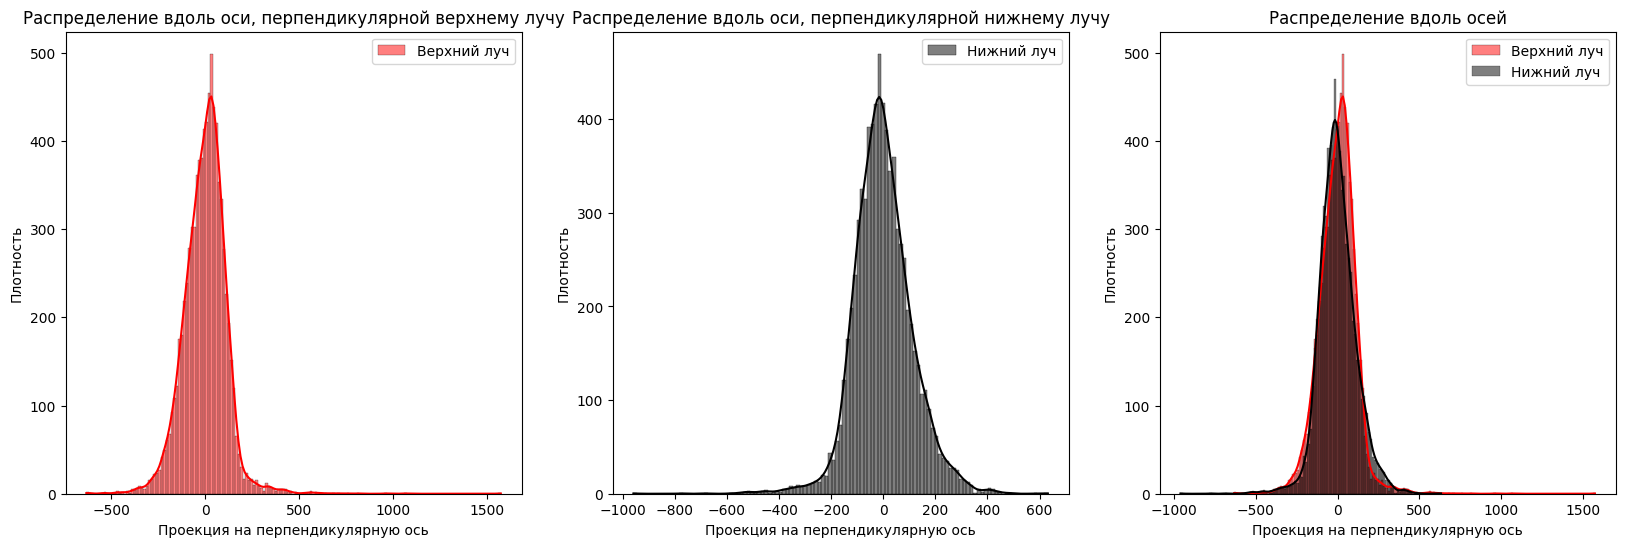

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Распределение проекций для верхнего луча
sns.histplot(df_up['projection_perp1'], kde=True, ax=ax[0], color='r', label='Верхний луч')
ax[0].set_title('Распределение вдоль оси, перпендикулярной верхнему лучу')
ax[0].set_xlabel('Проекция на перпендикулярную ось')
ax[0].set_ylabel('Плотность')
ax[0].legend()

# Распределение проекций для нижнего луча
sns.histplot(df_down['projection_perp2'], kde=True, ax=ax[1], color='black', label='Нижний луч')
ax[1].set_title('Распределение вдоль оси, перпендикулярной нижнему лучу')
ax[1].set_xlabel('Проекция на перпендикулярную ось')
ax[1].set_ylabel('Плотность')
ax[1].legend()

sns.histplot(df_up['projection_perp1'], kde=True, ax=ax[2], color='r', label='Верхний луч')
sns.histplot(df_down['projection_perp2'], kde=True, ax=ax[2], color='black', label='Нижний луч')
ax[2].set_title('Распределение вдоль осей')
ax[2].set_xlabel('Проекция на перпендикулярную ось')
ax[2].set_ylabel('Плотность')
ax[2].legend()

plt.show()

In [ ]:
# Для верхнего луча
mean_perp1 = np.mean(df_up['projection_perp1'])
variance_perp1 = np.var(df_up['projection_perp1'])
std_perp1 = np.std(df_down['projection_perp2'])

# Для нижнего луча
mean_perp2 = np.mean(df_down['projection_perp2'])
variance_perp2 = np.var(df_down['projection_perp2'])
std_perp2 = np.std(df_down['projection_perp2'])

print(f"Верхний луч: среднее = {mean_perp1}, дисперсия = {variance_perp1}")
print(f"Нижний луч: среднее = {mean_perp2}, дисперсия = {variance_perp2}")

Верхний луч: среднее = 5.962440804186516e-13, дисперсия = 12866.177303604232
Нижний луч: среднее = 9.268359800623106e-13, дисперсия = 12836.467170656533


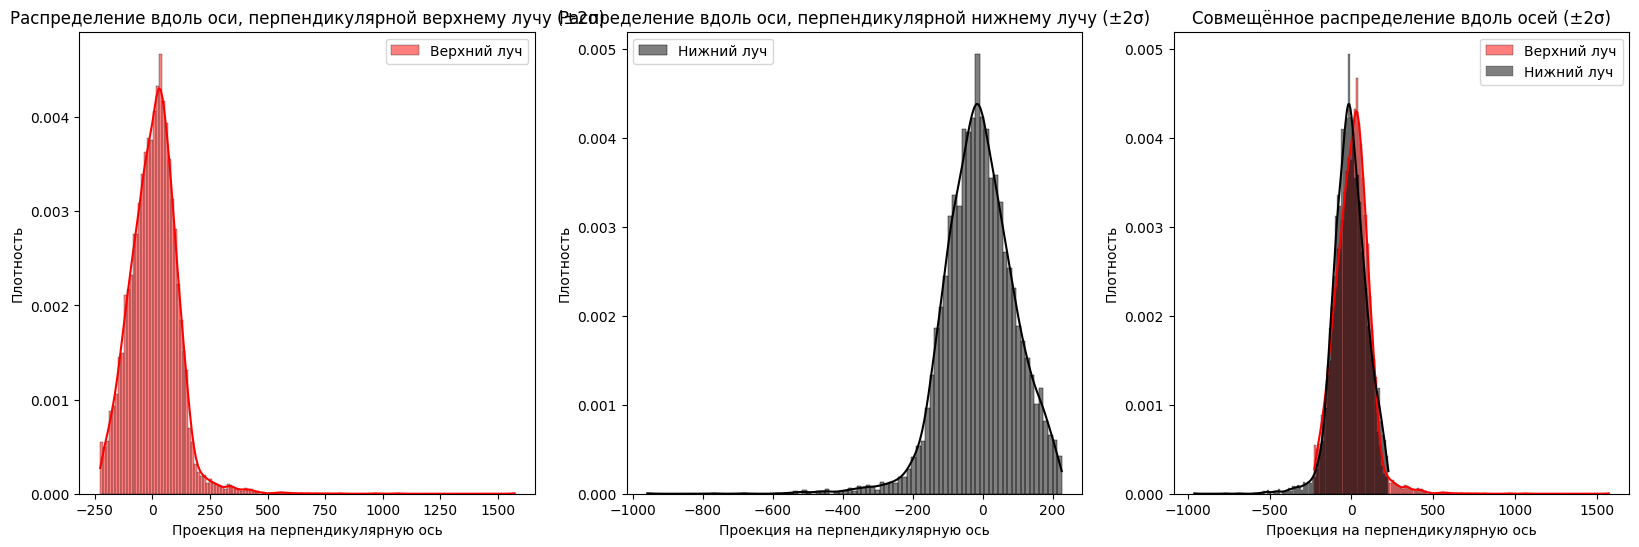

In [ ]:
# Фильтруем данные в диапазоне ±2 сигма
df_up_filtered = df_up[df_up['projection_perp1'] >= mean_perp1 - 2 * std_perp1]

df_down_filtered = df_down[df_down['projection_perp2'] <= mean_perp2 + 2 * std_perp2]

# Перестраиваем графики
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Распределение проекций для верхнего луча (отфильтрованное)
sns.histplot(df_up_filtered['projection_perp1'], kde=True, ax=ax[0], color='r', label='Верхний луч', stat="density")
ax[0].set_title('Распределение вдоль оси, перпендикулярной верхнему лучу (±2σ)')
ax[0].set_xlabel('Проекция на перпендикулярную ось')
ax[0].set_ylabel('Плотность')
ax[0].legend()

# Распределение проекций для нижнего луча (отфильтрованное)
sns.histplot(df_down_filtered['projection_perp2'], kde=True, ax=ax[1], color='black', label='Нижний луч', stat="density")
ax[1].set_title('Распределение вдоль оси, перпендикулярной нижнему лучу (±2σ)')
ax[1].set_xlabel('Проекция на перпендикулярную ось')
ax[1].set_ylabel('Плотность')
ax[1].legend()

# Совмещённое распределение (отфильтрованное)
sns.histplot(df_up_filtered['projection_perp1'], kde=True, ax=ax[2], color='r', label='Верхний луч', stat="density")
sns.histplot(df_down_filtered['projection_perp2'], kde=True, ax=ax[2], color='black', label='Нижний луч', stat="density")
ax[2].set_title('Совмещённое распределение вдоль осей (±2σ)')
ax[2].set_xlabel('Проекция на перпендикулярную ось')
ax[2].set_ylabel('Плотность')
ax[2].legend()

plt.show()

In [ ]:
from scipy.stats import gaussian_kde

bound_up = mean_perp1 - 2 * std_perp1
bound_down = mean_perp2 + 2 * std_perp2
kde_up = gaussian_kde(df_up_filtered['projection_perp1'])
kde_down = gaussian_kde(df_down_filtered['projection_perp2'])

def classify_point(row):
    s = row['s']
    a = row['a']
    projection_up = -s * np.sin(theta1) + (a-c1) * np.cos(theta1)
    projection_down = -s * np.sin(theta2) + (a-c2) * np.cos(theta2)
    density_up = kde_up(projection_up)
    density_down = kde_down(projection_down)

    # Проверить кластеры
    if projection_down <= bound_down and projection_up >= bound_up:
      if density_down >= 1 * density_up:
        return 1
      elif density_up >= 1.5 * density_down:
        return 0
      else:
        return 2 # неопр
    elif projection_down <= bound_down and projection_up <= bound_up:
        return 1  # Нижний луч
    elif projection_down >= bound_down and projection_up >= bound_up:
        return 0  # Верхний луч


df['cluster'] = df.apply(classify_point, axis=1)
df

,s,a,cluster
index,,,
0,5974,539,0
1,13095,1907,1
2,17948,2566,1
3,5223,573,0
4,12887,1800,1
...,...,...,...
23474,3295,512,1
23475,45791,5774,0
23476,39504,5004,0


In [ ]:
df['cluster'].value_counts()

,count
cluster,
1,13772
0,9336
2,371


(0.0, 2500.0)

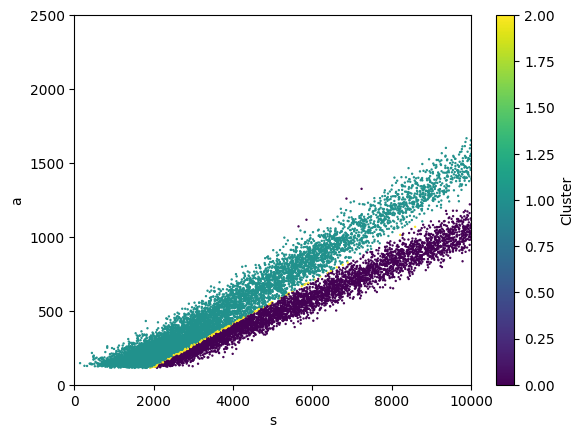

In [ ]:
plt.scatter(df['s'], df['a'], c=df['cluster'], cmap='viridis', s=0.5)
plt.xlabel('s')
plt.ylabel('a')
plt.colorbar(label='Cluster')
plt.xlim(0, 10000)
plt.ylim(0, 2500)

In [ ]:
X = df[['s', 'a']].values
y = df['cluster'].values
silhouette_avg = silhouette_score(X, y)
calinski_harabasz_index = calinski_harabasz_score(X, y)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Score: {calinski_harabasz_index}")

Silhouette Score: -0.4537052832948069
Score: 250.21681154727375


In [ ]:
out = df['cluster'].sort_values()
out.to_csv('out.csv', header=True, index=True)
out

,cluster
index,
0,0
8701,0
8704,0
8706,0
18006,0
...,...
8013,2
935,2
9953,2
